## Project: Million Playlist Dataset

## A. Data
In this project, you will implement a data processing pipeline for analyzing music playlists. We
will use the Million Playlist Dataset published by Spotify, discussed here: https://www.aicrowd.
com/challenges/spotify-million-playlist-dataset-challenge, and available to download here: https://www.kaggle.com/datasets/himanshuwagh/spotify-million/data.
The dataset contains one million playlists, where each playlist contains information about the playlist
itself (e.g., playlist title, duration) and each track it contains (e.g., track id, artist id, track name,
duration). The dataset was used as part of a “playlist continuation” challenge: given a playlist name
and a few tracks, predict which other tracks would fit best with that playlist.

## B. Tasks
In this project, you are asked to address the following tasks.
1. Present your approach to handling this big dataset. Given that the dataset is big, at about 35 GB,
you are not expected to be able to process all of it. Ideally, of course, you should have a solution
that scales to the whole dataset. Describe the approach you took and all the alternatives you
considered.
2. Present some interesting statistical/aggregate information about the dataset. Explain how you
derived the presented information.
3. Propose a definition of similarity between tracks. Specifically, given two tracks, their similarity
is a score from 0 to 1, where 0 indicates that the two tracks are not similar at all, and 1 indicates
that the two tracks are identical. Design a method to compute those similarity scores using the
dataset. Discuss the implementation and give some examples.
4. Propose a definition of similarity (score ranging from 0 to 1) between playlists. Design a method
to compute this similarity score using the dataset. Discuss the implementation and give some
examples.
5. Propose a method to solve the “playlist continuation” challenge. Discuss the implementation
and give some examples.
You should write the code in Python, and you are free to use the tools and frameworks (e.g., Spark,
Dask) that we have discussed in this course as well as others.


## Our approach
 1. 1st step : load the first slice and explore how it look likes (task 0 - setup)
 2. 2nd step : Generate and load a random sample df among the slices (task 1)
 3. 3rd step : Derive all analytics in a main function to run on the sampled df (task 2)
 4. 4th step : Build and define the track_similarity_score function based on analytics and sampled df (task 3)
 4. 5th step : Build and define the playlist_similarity_score function based on analytics and sampled df (task 4)
 5. 6th step : Build and define the "next track" algorithm based on the similarity_score (task 5)
 6. 7th step : To scale => generate the whole df containing all slices then re-run step 3-5 on this df. Eventually compare analytics of sample_df and final_df to assess robustness and adjust 4th-6th steps if needed. (Only if able to compute the final_df)

## Task 0 : Initialization
0. Create venv (temp env for the project with used packages etc, can be removed after project) with prompt: 
    conda create venv --name pyspark_env python=3.9 pyspark openjdk=17 -c conda-forge
    conda activate pyspark_env
1. Note to self : solving issues setting up sparks : <br>
- set up new conda envs forcing python 3.9 <br>
- set up java-jdk forcing v.17 <br>
- set up winutils.exe in depository "C:\hadoop\bin" <br>
- Add setup settings to the session <br>
- After conda activate pyspark_env => install required packages : 
- conda install matplotlib <br>
- conda install ipykernel <br>
2. Get the data : <br>
- Downloaded the dataset from kaggle and unzipped it in my G-Drive.
- For faster computin, transfered the dataset to local disk c:\\

In [3]:
import os
from pyspark.sql import SparkSession

# Ensure local temp directory exists for Spark
_tmp = os.environ.get("SPARK_LOCAL_DIR", "C:/temp/spark")
try:
    os.makedirs(_tmp, exist_ok=True)
except Exception:
    _tmp = "C:/temp/spark"
    os.makedirs(_tmp, exist_ok=True)

# Stable local Spark configuration
spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("MPD_Project")
    # Memory and temp settings
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "2g")
    .config("spark.local.dir", _tmp)
    # Disable dynamic allocation / speculative tasks for Windows stability
    .config("spark.dynamicAllocation.enabled", "false")
    .config("spark.speculation", "false")
    # Reduce shuffle partitions for local workloads
    .config("spark.sql.shuffle.partitions", "8")
    # Reduce logging verbosity
    .config("spark.ui.showConsoleProgress", "false")
    .config("spark.eventLog.enabled", "false")
    .getOrCreate()
)

# Set log level to WARN to reduce console output
spark.sparkContext.setLogLevel("WARN")

# Quick ping to ensure session is usable
_ = spark.range(1).count()
print("✓ Spark session initialized")

✓ Spark session initialized


## Task 0a : load explore_df (1th slice)

In [4]:
from pyspark.sql.functions import col, explode

BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"
file_path = os.path.join(BASE_FOLDER, "mpd.slice.0-999.json")

if os.path.exists(file_path):
    df_raw = spark.read.option("multiline", True).json(file_path)
    explore_df = (
        df_raw
        .select(explode("playlists").alias("playlist"))
        .select(
            col("playlist.pid").alias("playlist_id"),
            col("playlist.name").alias("playlist_name"),
            explode("playlist.tracks").alias("track")
        )
        .select(
            col("playlist_id"),
            col("playlist_name"),
            col("track.pos").alias("track_position"),
            col("track.artist_name").alias("artist_name"),
            col("track.track_name").alias("track_name"),
            col("track.album_name").alias("album_name"),
            col("track.duration_ms").alias("duration_ms")
        )
    )

    print(f"✓ Dataset loaded: {explore_df.count()} tracks")
    explore_df.printSchema()
    explore_df.show(5, truncate=False)
else:
    print(f"ERROR: File not found at {file_path}")

✓ Dataset loaded: 67503 tracks
root
 |-- playlist_id: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- track_position: long (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- duration_ms: long (nullable = true)

+-----------+-------------+--------------+-----------------+------------------------------------------+--------------------------------------------+-----------+
|playlist_id|playlist_name|track_position|artist_name      |track_name                                |album_name                                  |duration_ms|
+-----------+-------------+--------------+-----------------+------------------------------------------+--------------------------------------------+-----------+
|0          |Throwbacks   |0             |Missy Elliott    |Lose Control (feat. Ciara & Fat Man Scoop)|The Cookbook                                |226863     |
|0          |Throwbac

## Task : 0b visualize explore_df

=== Dataset Overview ===
Total tracks: 67,503
Unique playlists: 1,000
Unique artists: 9,722
Unique tracks: 34,250

=== Top 10 Artists ===
+--------------+-----------+
|artist_name   |track_count|
+--------------+-----------+
|Drake         |939        |
|Kanye West    |415        |
|Kendrick Lamar|385        |
|Rihanna       |350        |
|Eminem        |332        |
|The Weeknd    |296        |
|Lil Uzi Vert  |292        |
|Ed Sheeran    |285        |
|Future        |265        |
|Chris Brown   |259        |
+--------------+-----------+


=== Playlist Size Stats ===
+-------+-----------------+
|summary|       num_tracks|
+-------+-----------------+
|  count|             1000|
|   mean|           67.503|
| stddev|55.00333952005419|
|    min|                5|
|    max|              245|
+-------+-----------------+



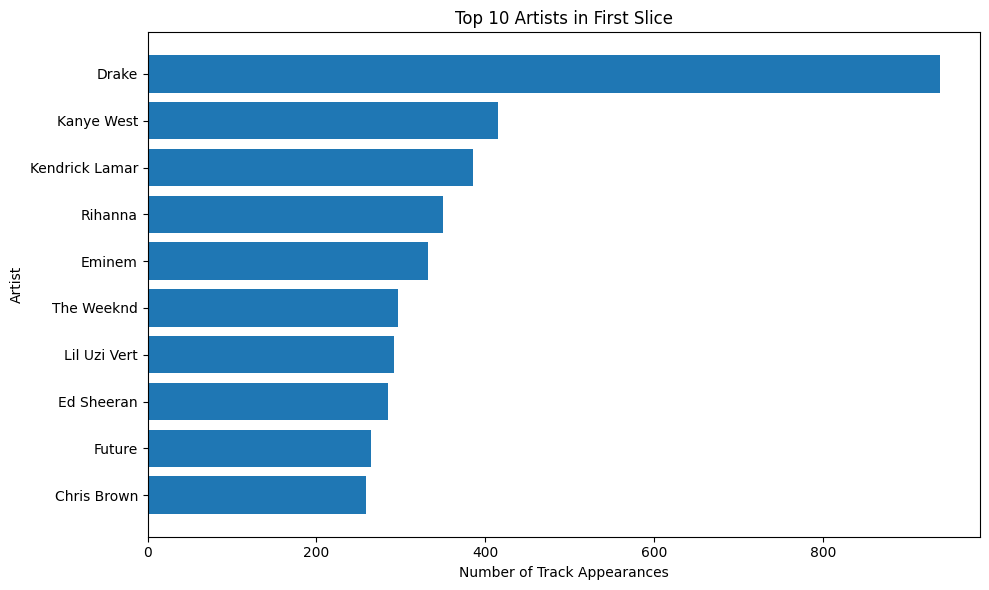

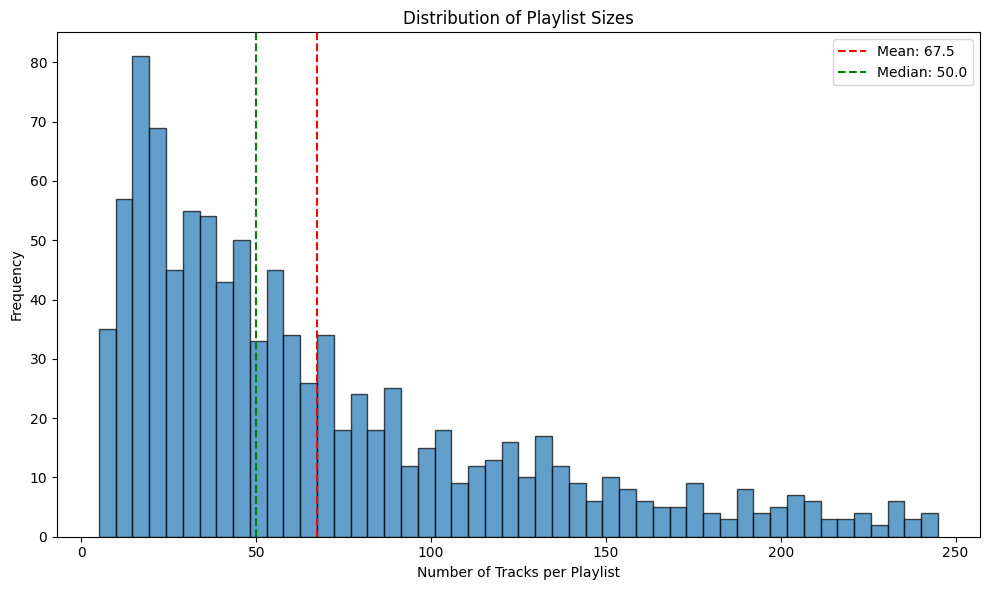


=== Track Duration Stats (ms) ===
+-------+------------------+
|summary|       duration_ms|
+-------+------------------+
|  count|             67503|
|   mean|233183.90283394812|
| stddev| 64552.34264440953|
|    min|                 0|
|    max|           2424189|
+-------+------------------+



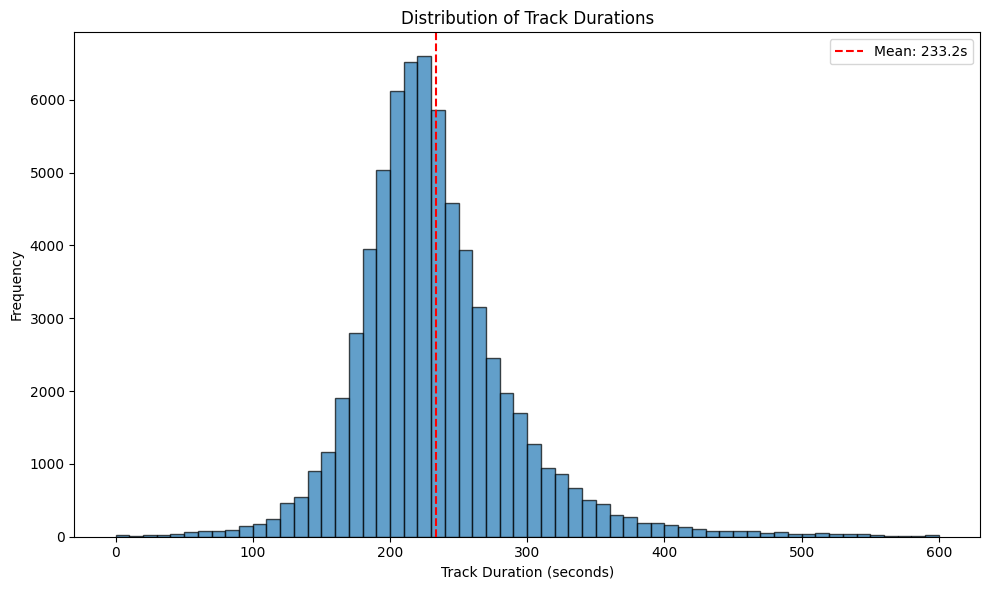

In [5]:
# Quick exploration & visualization of explore_df (first slice)
from pyspark.sql.functions import count, avg, col
import matplotlib.pyplot as plt
import pandas as pd
# Basic stats
print("=== Dataset Overview ===")
print(f"Total tracks: {explore_df.count():,}")
print(f"Unique playlists: {explore_df.select('playlist_id').distinct().count():,}")
print(f"Unique artists: {explore_df.select('artist_name').distinct().count():,}")
print(f"Unique tracks: {explore_df.select('track_name', 'artist_name').distinct().count():,}")

# Top artists by frequency
print("\n=== Top 10 Artists ===")

top_artists = explore_df.groupBy("artist_name") \
    .agg(count("*").alias("track_count")) \
    .orderBy(col("track_count").desc()) \
    .limit(10)
top_artists.show(truncate=False)

# Playlist size distribution
print("\n=== Playlist Size Stats ===")
playlist_sizes = explore_df.groupBy("playlist_id") \
    .agg(count("*").alias("num_tracks"))
playlist_sizes.describe("num_tracks").show()

# Top artists bar chart
top_artists_pd = top_artists.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_artists_pd['artist_name'], top_artists_pd['track_count'])
plt.xlabel('Number of Track Appearances')
plt.ylabel('Artist')
plt.title('Top 10 Artists in First Slice')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Playlist size distribution histogram
playlist_sizes_pd = playlist_sizes.toPandas()
plt.figure(figsize=(10, 6))
plt.hist(playlist_sizes_pd['num_tracks'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Tracks per Playlist')
plt.ylabel('Frequency')
plt.title('Distribution of Playlist Sizes')
plt.axvline(playlist_sizes_pd['num_tracks'].mean(), color='red', linestyle='--', label=f"Mean: {playlist_sizes_pd['num_tracks'].mean():.1f}")
plt.axvline(playlist_sizes_pd['num_tracks'].median(), color='green', linestyle='--', label=f"Median: {playlist_sizes_pd['num_tracks'].median():.1f}")
plt.legend()
plt.tight_layout()
plt.show()

# Track duration analysis
print("\n=== Track Duration Stats (ms) ===")
explore_df.select("duration_ms").describe().show()

duration_pd = explore_df.select("duration_ms").toPandas()
duration_pd['duration_sec'] = duration_pd['duration_ms'] / 1000

plt.figure(figsize=(10, 6))
plt.hist(duration_pd['duration_sec'], bins=60, range=(0, 600), edgecolor='black', alpha=0.7)
plt.xlabel('Track Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Track Durations')
plt.axvline(duration_pd['duration_sec'].mean(), color='red', linestyle='--', label=f"Mean: {duration_pd['duration_sec'].mean():.1f}s")
plt.legend()
plt.tight_layout()
plt.show()

## Task 1 : load sample_df
> Reflexion : 
>> How can we handle the dataset to minimize computing time and induced bias through sampling <br>
>> What do we know of the slices ? Are they compoped of random playlist or is there any sorting/grouping ? <br>
> 1. Method 1 : Simply select every nth slice (determinist)
> 2. Method 2 : Select n slices randomly
> 3. Method 3 : Select n random slices then k random playlists

## Task 1a : build helpers for various sampling & loading strategies

In [6]:
# --- Helpers: slice listing, reading, playlist/track transforms ---
import glob
import random
from pyspark.sql import functions as F

def list_slices(base_folder, pattern="mpd.slice.*.json"):
    """Return sorted list of slice file paths."""
    return sorted(glob.glob(f"{base_folder}/{pattern}"))

def read_slices(slices):
    """Read one or many JSON slice files into a Spark DataFrame."""
    return spark.read.option("multiline", "true").json(slices)

def playlists_df_from_raw(df_raw):
    """Explode raw df into one row per playlist, keeping nested tracks."""
    return df_raw.select(F.explode("playlists").alias("playlist")) \
                 .select(
                     F.col("playlist.pid").alias("playlist_id"),
                     F.col("playlist.name").alias("playlist_name"),
                     F.col("playlist.tracks").alias("tracks")
                 )

def tracks_df_from_playlists(playlists_df):
    """Explode playlist-level df into one row per track (tracks-level)."""
    return playlists_df.select(F.col("playlist_id"), F.col("playlist_name"), F.explode("tracks").alias("track")) \
                       .select(
                           "playlist_id",
                           "playlist_name",
                           F.col("track.pos").alias("track_position"),
                           F.col("track.artist_name").alias("artist_name"),
                           F.col("track.track_name").alias("track_name"),
                           F.col("track.album_name").alias("album_name"),
                           F.col("track.duration_ms").alias("duration_ms")
                       )

def random_choose_slices(slice_files, k, seed=42):
    random.seed(seed)
    return random.sample(slice_files, min(k, len(slice_files)))

#### Method 1 : Select every nth slices (determinist)

In [7]:
# Method 1 : Deterministic every-nth slices sampling

# Parameters
NTH = 10  # take every NTH slice
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

slice_files = list_slices(BASE_FOLDER)
sample_files = slice_files[::NTH]
print(f"Method 1: taking every {NTH}th slice → {len(sample_files)} files")

# Read and flatten to playlist-level
df_raw = read_slices(sample_files)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
M1_sample_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostic
print(f"M1_sample_df ready (tracks-level). Example rows:")
M1_sample_df.show(5, truncate=False)


Method 1: taking every 10th slice → 100 files
M1_sample_df ready (tracks-level). Example rows:
+-----------+-------------+--------------+--------------------+-----------------------------+--------------------------------+-----------+
|playlist_id|playlist_name|track_position|artist_name         |track_name                   |album_name                      |duration_ms|
+-----------+-------------+--------------+--------------------+-----------------------------+--------------------------------+-----------+
|675000     |Light        |0             |Desert Dwellers     |Union - Groove Mix           |Anahata Yoga Dub                |558000     |
|675000     |Light        |1             |Syndicate Sound Labs|Swimming Pools - Instrumental|Kendrick's Instrumentals, Vol. 1|220943     |
|675000     |Light        |2             |Dr. Toast           |Light                        |Gravity is Quiet                |334173     |
|675000     |Light        |3             |Desert Dwellers     |Wanderin

#### Method 2 : Random slice

In [8]:
# Method 2 : Random slices sampling

# Parameters
k = 100   # number of slices to pick
SEED = 42
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

# List slices and choose randomly
slice_files = list_slices(BASE_FOLDER)
chosen = random_choose_slices(slice_files, k, seed=SEED)
print(f"Chosen {len(chosen)} slices (out of {len(slice_files)})")

# Read chosen slices and flatten to playlist-level
df_raw = read_slices(chosen)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
M2_sample_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostic
print("M2_sample_df ready (tracks-level). Example rows:")
M2_sample_df.show(5, truncate=False)

Chosen 100 slices (out of 1000)
M2_sample_df ready (tracks-level). Example rows:
+-----------+-------------+--------------+-----------------+-------------------------------+-------------------------------+-----------+
|playlist_id|playlist_name|track_position|artist_name      |track_name                     |album_name                     |duration_ms|
+-----------+-------------+--------------+-----------------+-------------------------------+-------------------------------+-----------+
|300000     |April 2017   |0             |Lia Marie Johnson|Cold Heart Killer              |Cold Heart Killer              |212071     |
|300000     |April 2017   |1             |blackbear        |do re mi                       |digital druglord               |212027     |
|300000     |April 2017   |2             |SoMo             |Curve                          |The Answers                    |188093     |
|300000     |April 2017   |3             |mansionz         |STFU                           |Mansi

#### Method 3 : Random slice + random playlist

In [9]:
# Method 3 : Random slices + random playlists sampling

# Parameters
K_SLICES = 200   # number of slices to randomly load
N_PLAYLISTS = 100000  # target playlists
SEED = 42
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

slice_files = list_slices(BASE_FOLDER)
chosen = random_choose_slices(slice_files, K_SLICES, seed=SEED)
print(f"Method 3: chosen {len(chosen)} random slices")

# Read chosen slices and flatten to playlists-level
df_raw = read_slices(chosen)
playlists_df = playlists_df_from_raw(df_raw)

# Use sample() instead of orderBy to avoid shuffle issues
sample_fraction = min(1.0, N_PLAYLISTS / playlists_df.count() * 1.2)  # 20% buffer
sample_playlists = playlists_df.sample(fraction=sample_fraction, seed=SEED).limit(N_PLAYLISTS)

# Flatten to tracks-level and cache
M3_sample_df = tracks_df_from_playlists(sample_playlists).cache()

# Minimal diagnostics
print("M3_sample_df ready (tracks-level).")
print(f"Total playlists sampled: {M3_sample_df.select('playlist_id').distinct().count()}")
print(f"Total tracks: {M3_sample_df.count()}")


Method 3: chosen 200 random slices
M3_sample_df ready (tracks-level).
Total playlists sampled: 100000
Total tracks: 6689682


#### Compare samples

SAMPLING METHODS COMPARISON

                         Method  Total Tracks  Unique Playlists  Unique Artists  Unique Tracks  Avg Playlist Size
          M1 (Every 10th slice)       6633713            100000          108537         669453           66.33713
         M2 (100 random slices)       6624113            100000          108479         671849           66.24113
M3 (200 slices, 100k playlists)       6689682            100000          108113         673189           66.89682


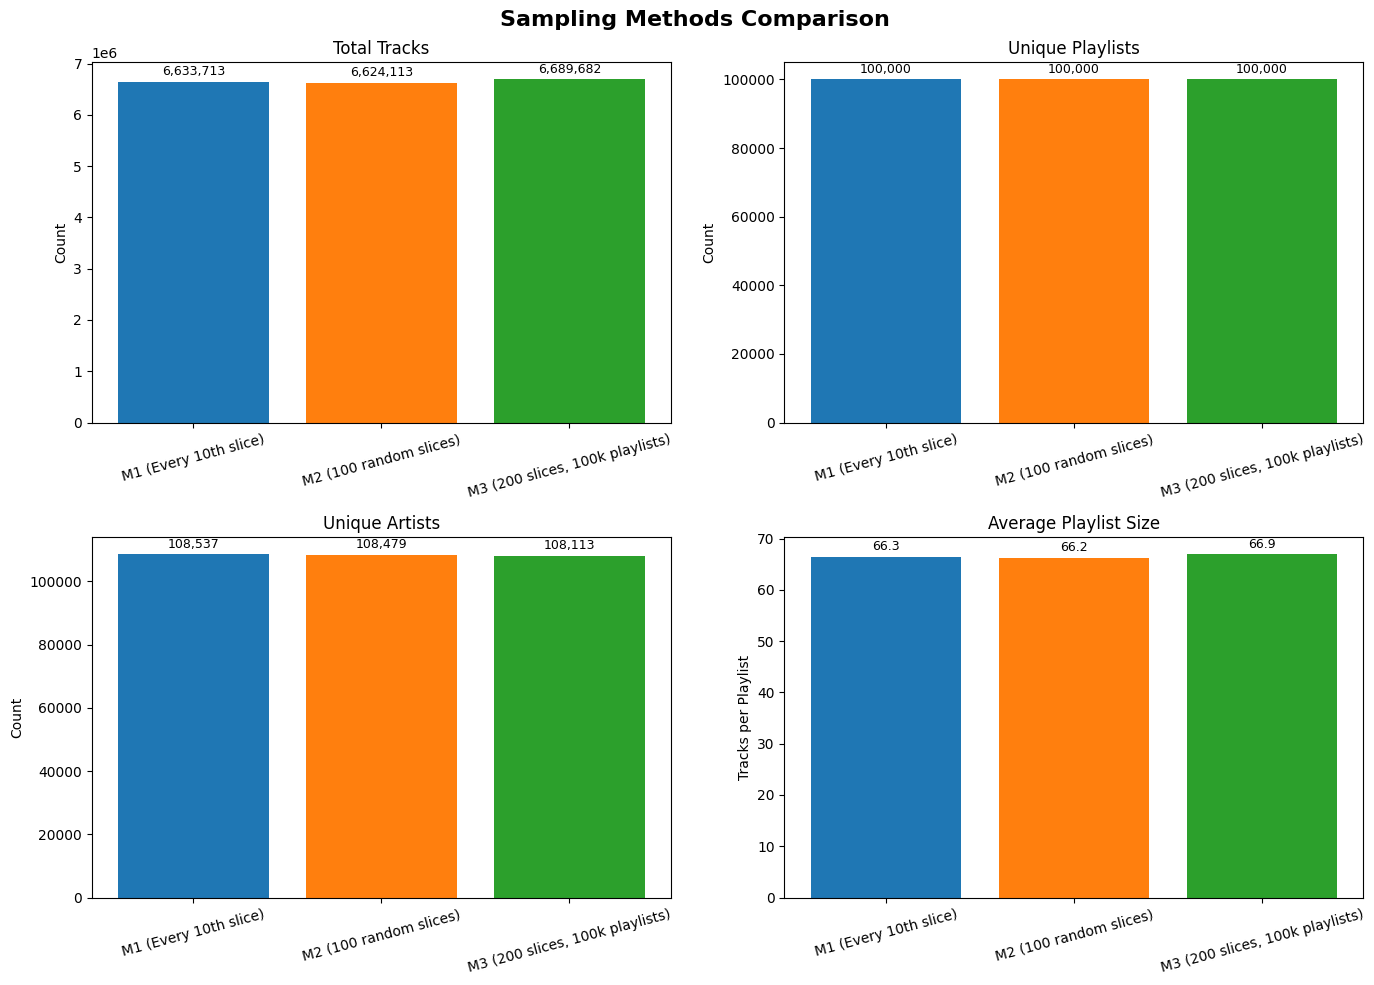


COVERAGE ANALYSIS (vs. Complete Dataset)

Dataset totals: 1,000,000 playlists | 295,860 artists | 2,262,292 tracks

M1 (Every 10th slice):
  Playlists: 100,000 (10.00%)
  Artists: 108,537 (36.69%)
  Tracks: 6,633,713 (9.999%)
  Diversity: 16.4 artists per 1000 tracks

M2 (100 random slices):
  Playlists: 100,000 (10.00%)
  Artists: 108,479 (36.67%)
  Tracks: 6,624,113 (9.984%)
  Diversity: 16.4 artists per 1000 tracks

M3 (200 slices, 100k playlists):
  Playlists: 100,000 (10.00%)
  Artists: 108,113 (36.54%)
  Tracks: 6,689,682 (10.083%)
  Diversity: 16.2 artists per 1000 tracks

✓ Comparison complete. Method recommendations:
  - M1: Best for broad coverage (deterministic, spans dataset evenly)
  - M2: Good balance of diversity and size
  - M3: Smallest, fastest, good for prototyping specific playlist patterns


In [10]:
# Quick comparison of sampling methods (M1, M2, M3)
from pyspark.sql.functions import count, countDistinct, avg, col

print("=" * 80)
print("SAMPLING METHODS COMPARISON")
print("=" * 80)

# Define samples to compare
samples = [
    ("M1 (Every 10th slice)", M1_sample_df),
    ("M2 (100 random slices)", M2_sample_df),
    ("M3 (200 slices, 100k playlists)", M3_sample_df)
]

# Collect metrics for each sample
comparison_data = []
for name, df in samples:
    metrics = {
        "Method": name,
        "Total Tracks": df.count(),
        "Unique Playlists": df.select("playlist_id").distinct().count(),
        "Unique Artists": df.select("artist_name").distinct().count(),
        "Unique Tracks": df.select("track_name", "artist_name").distinct().count(),
        "Avg Playlist Size": df.groupBy("playlist_id").agg(count("*").alias("size")).agg(avg("size")).collect()[0][0]
    }
    comparison_data.append(metrics)

# Display comparison table
import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Visual comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Sampling Methods Comparison', fontsize=16, fontweight='bold')

# Total tracks comparison
ax = axes[0, 0]
ax.bar(comparison_df['Method'], comparison_df['Total Tracks'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Total Tracks')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Total Tracks']):
    ax.text(i, v + max(comparison_df['Total Tracks'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Unique playlists comparison
ax = axes[0, 1]
ax.bar(comparison_df['Method'], comparison_df['Unique Playlists'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Unique Playlists')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Unique Playlists']):
    ax.text(i, v + max(comparison_df['Unique Playlists'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Unique artists comparison
ax = axes[1, 0]
ax.bar(comparison_df['Method'], comparison_df['Unique Artists'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Count')
ax.set_title('Unique Artists')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Unique Artists']):
    ax.text(i, v + max(comparison_df['Unique Artists'])*0.02, f"{v:,}", ha='center', fontsize=9)

# Average playlist size comparison
ax = axes[1, 1]
ax.bar(comparison_df['Method'], comparison_df['Avg Playlist Size'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Tracks per Playlist')
ax.set_title('Average Playlist Size')
ax.tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Avg Playlist Size']):
    ax.text(i, v + max(comparison_df['Avg Playlist Size'])*0.02, f"{v:.1f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# True coverage analysis (values from kaggle/stats.txt)
TOTAL_PLAYLISTS = 1_000_000
TOTAL_TRACKS = 66_346_428
TOTAL_UNIQUE_TRACKS = 2_262_292
TOTAL_UNIQUE_ARTISTS = 295_860
TOTAL_UNIQUE_ALBUMS = 734_684

print("\n" + "=" * 80)
print("COVERAGE ANALYSIS (vs. Complete Dataset)")
print("=" * 80)
print(f"\nDataset totals: {TOTAL_PLAYLISTS:,} playlists | {TOTAL_UNIQUE_ARTISTS:,} artists | {TOTAL_UNIQUE_TRACKS:,} tracks")

for i, row in comparison_df.iterrows():
    print(f"\n{row['Method']}:")
    print(f"  Playlists: {row['Unique Playlists']:,} ({row['Unique Playlists']/TOTAL_PLAYLISTS*100:.2f}%)")
    print(f"  Artists: {row['Unique Artists']:,} ({row['Unique Artists']/TOTAL_UNIQUE_ARTISTS*100:.2f}%)")
    print(f"  Tracks: {row['Total Tracks']:,} ({row['Total Tracks']/TOTAL_TRACKS*100:.3f}%)")
    diversity_ratio = (row['Unique Artists'] / row['Total Tracks']) * 1000
    print(f"  Diversity: {diversity_ratio:.1f} artists per 1000 tracks")

print("\n✓ Comparison complete. Method recommendations:")
print("  - M1: Best for broad coverage (deterministic, spans dataset evenly)")
print("  - M2: Good balance of diversity and size")
print("  - M3: Smallest, fastest, good for prototyping specific playlist patterns")

## Task 2 : define main analysis (to run on samples)

In [9]:
## block for task 2

## Task 3 : define scoring function 

In [10]:
## block for task 3

## Task 4 : define next track algorithm

In [11]:
## block for task 4

## Task 5 : Scaling - load complete_df and apply task 2-4 + fine tuning if needed

In [11]:
# Load all slices using helpers and build tracks-level complete_df
BASE_FOLDER = r"C:\Users\nrnor\Documents\Master BGDA\INFO-H600\Project\kaggle\data"

# List all slice files
slice_files = list_slices(BASE_FOLDER)
print(f"Task 5: loading {len(slice_files)} slices into complete_df")

# Read and flatten to playlists-level
df_raw = read_slices(slice_files)
playlists_df = playlists_df_from_raw(df_raw)

# Flatten to tracks-level and cache
complete_df = tracks_df_from_playlists(playlists_df).cache()

# Minimal diagnostics
print("complete_df ready (tracks-level). Example rows:")
complete_df.show(5, truncate=False)

Task 5: loading 1000 slices into complete_df
complete_df ready (tracks-level). Example rows:
+-----------+-------------+--------------+-------------+----------------------+---------------------+-----------+
|playlist_id|playlist_name|track_position|artist_name  |track_name            |album_name           |duration_ms|
+-----------+-------------+--------------+-------------+----------------------+---------------------+-----------+
|834000     |pump         |0             |Post Malone  |What's up (feat. 1st) |What's up (feat. 1st)|290533     |
|834000     |pump         |1             |Bryson Tiller|Don't                 |T R A P S O U L      |198293     |
|834000     |pump         |2             |Lil Durk     |Like Me               |Remember My Name     |238439     |
|834000     |pump         |3             |Young Thug   |Check                 |Barter 6             |230693     |
|834000     |pump         |4             |Young Thug   |With That (feat. Duke)|Barter 6             |202533  

## Task 5b : Visualize complete_df

=== Complete Dataset Overview ===
Total tracks: 66,346,428
Total tracks: 66,346,428
Unique playlists: 1,000,000
Unique playlists: 1,000,000
Unique artists: 287,742
Unique artists: 287,742
Unique tracks: 2,189,699

=== Top 10 Artists ===
Unique tracks: 2,189,699

=== Top 10 Artists ===
+--------------+-----------+
|artist_name   |track_count|
+--------------+-----------+
|Drake         |847160     |
|Kanye West    |413297     |
|Kendrick Lamar|353624     |
|Rihanna       |339570     |
|The Weeknd    |316603     |
|Eminem        |294667     |
|Ed Sheeran    |272116     |
|Future        |250734     |
|Justin Bieber |243119     |
|J. Cole       |241560     |
+--------------+-----------+


=== Playlist Size Stats ===
+--------------+-----------+
|artist_name   |track_count|
+--------------+-----------+
|Drake         |847160     |
|Kanye West    |413297     |
|Kendrick Lamar|353624     |
|Rihanna       |339570     |
|The Weeknd    |316603     |
|Eminem        |294667     |
|Ed Sheeran    |2

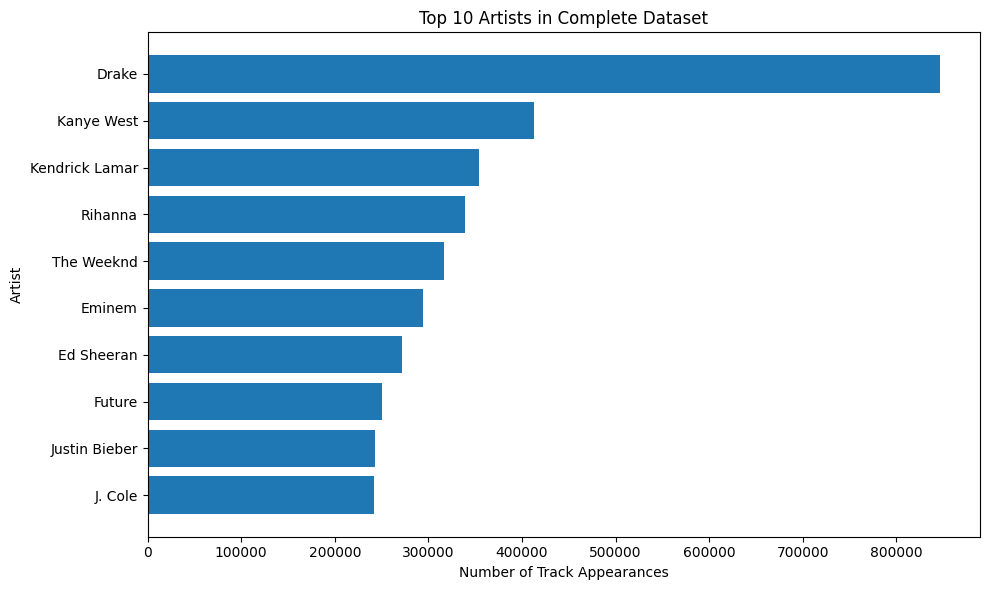

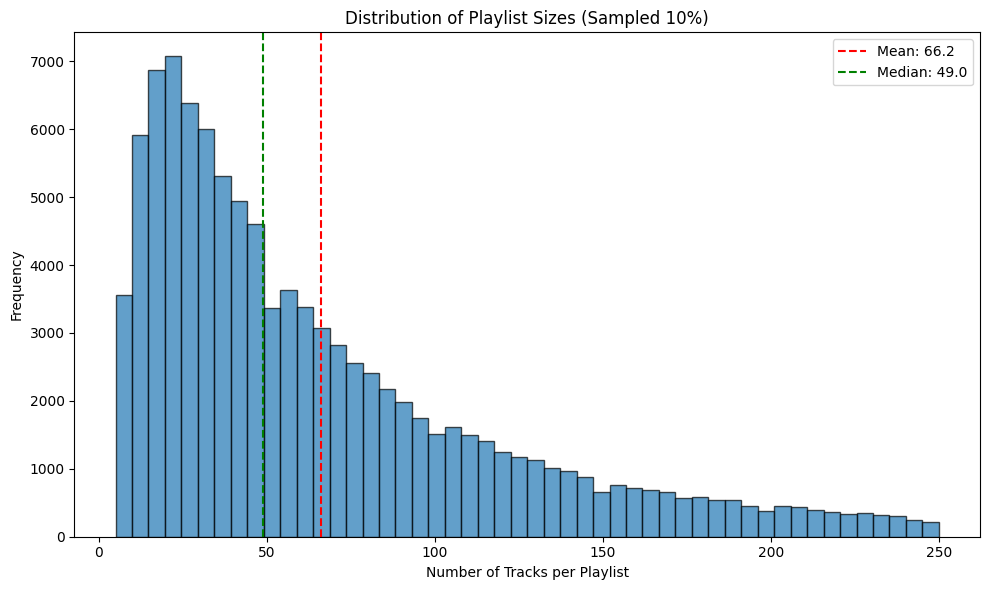


=== Track Duration Stats (ms) ===
+-------+------------------+
|summary|       duration_ms|
+-------+------------------+
|  count|          66346428|
|   mean|234823.14440044912|
| stddev| 74557.40223751558|
|    min|                -1|
|    max|          20744575|
+-------+------------------+

+-------+------------------+
|summary|       duration_ms|
+-------+------------------+
|  count|          66346428|
|   mean|234823.14440044912|
| stddev| 74557.40223751558|
|    min|                -1|
|    max|          20744575|
+-------+------------------+



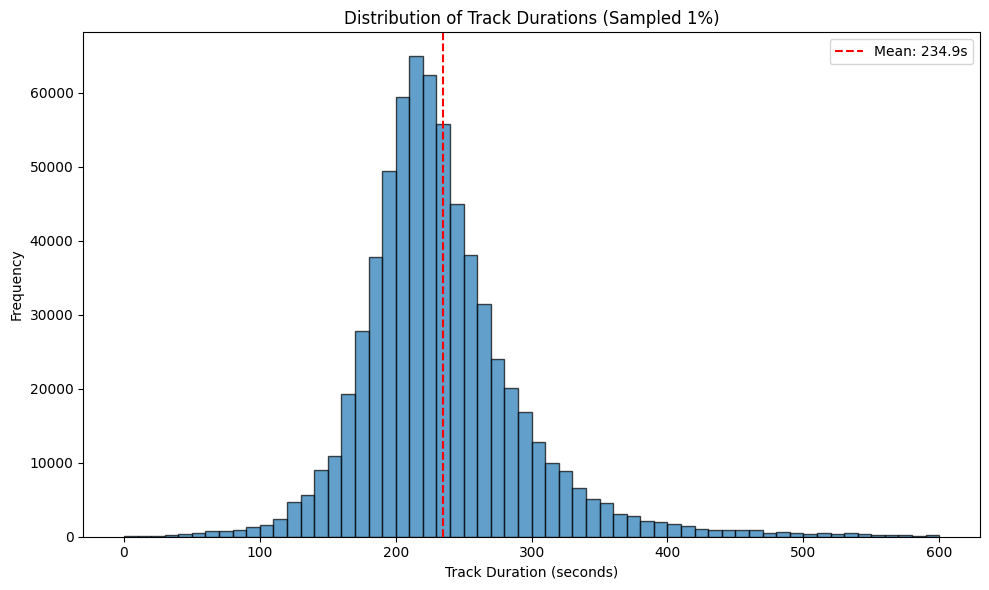

In [14]:
# Quick exploration & visualization of complete_df (all slices)
from pyspark.sql.functions import count, avg, col
import matplotlib.pyplot as plt
import pandas as pd

# Basic stats
print("=== Complete Dataset Overview ===")
print(f"Total tracks: {complete_df.count():,}")
print(f"Unique playlists: {complete_df.select('playlist_id').distinct().count():,}")
print(f"Unique artists: {complete_df.select('artist_name').distinct().count():,}")
print(f"Unique tracks: {complete_df.select('track_name', 'artist_name').distinct().count():,}")

# Top artists by frequency
print("\n=== Top 10 Artists ===")

top_artists = complete_df.groupBy("artist_name") \
    .agg(count("*").alias("track_count")) \
    .orderBy(col("track_count").desc()) \
    .limit(10)
top_artists.show(truncate=False)

# Playlist size distribution
print("\n=== Playlist Size Stats ===")
playlist_sizes = complete_df.groupBy("playlist_id") \
    .agg(count("*").alias("num_tracks"))
playlist_sizes.describe("num_tracks").show()

# Top artists bar chart
top_artists_pd = top_artists.toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_artists_pd['artist_name'], top_artists_pd['track_count'])
plt.xlabel('Number of Track Appearances')
plt.ylabel('Artist')
plt.title('Top 10 Artists in Complete Dataset')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Playlist size distribution histogram
# NOTE: Sampling 10% for visualization to avoid OOM on 1M+ playlists
playlist_sizes_pd = playlist_sizes.sample(fraction=0.1, seed=42).toPandas()
plt.figure(figsize=(10, 6))
plt.hist(playlist_sizes_pd['num_tracks'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Tracks per Playlist')
plt.ylabel('Frequency')
plt.title('Distribution of Playlist Sizes (Sampled 10%)')
plt.axvline(playlist_sizes_pd['num_tracks'].mean(), color='red', linestyle='--', label=f"Mean: {playlist_sizes_pd['num_tracks'].mean():.1f}")
plt.axvline(playlist_sizes_pd['num_tracks'].median(), color='green', linestyle='--', label=f"Median: {playlist_sizes_pd['num_tracks'].median():.1f}")
plt.legend()
plt.tight_layout()
plt.show()

# Track duration analysis
print("\n=== Track Duration Stats (ms) ===")
complete_df.select("duration_ms").describe().show()

# NOTE: Sampling 1% for visualization to avoid OOM on 66M+ tracks
# Collecting 66M rows to Pandas requires >1GB RAM just for the array, causing Java Heap Space error.
duration_pd = complete_df.select("duration_ms").sample(fraction=0.01, seed=42).toPandas()
duration_pd['duration_sec'] = duration_pd['duration_ms'] / 1000

plt.figure(figsize=(10, 6))
plt.hist(duration_pd['duration_sec'], bins=60, range=(0, 600), edgecolor='black', alpha=0.7)
plt.xlabel('Track Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Track Durations (Sampled 1%)')
plt.axvline(duration_pd['duration_sec'].mean(), color='red', linestyle='--', label=f"Mean: {duration_pd['duration_sec'].mean():.1f}s")
plt.legend()
plt.tight_layout()
plt.show()

## End block

In [ ]:
##spark.stop()